In [199]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import utility
import pandas as pd
import json
import seaborn as sns
import scipy.stats
import uuid
from tqdm import tqdm
import math

# O(n)
def bottomk_indices(v, k):
    return np.argpartition(v, k)[:k]

def not_indices(indices, shape):
    new_indices = np.ones(shape, dtype=bool)
    new_indices[indices] = False
    return new_indices

def normalize(x):
    min = np.min(x)
    max = np.max(x)
    if min == max:
        return x
    return ((x - min) /
            (max - min))

def clamp(x):
    return np.clip(x, 0, 1)

In [2]:
# parameters
number_of_neurons_in_network = 100
bottomk_ratio = 0.1
learning_rate = 0.1
training_iterations = 14

In [3]:
class Network:
    
    def __init__(self, D):
        # D are the values of the neurons
        self.D = D
        # W are the weights of the neurons
        self.W = np.ones(D.shape[0]) / 2
        self.bottomk_number = round(bottomk_ratio * number_of_neurons_in_network)
    
    @classmethod
    def generate_initial(cls, X):
        n_dims = X.shape[1]
        ranges = []
        for col_idx in range(n_dims):
            col_values = X[:, col_idx]
            min = np.min(col_values)
            max = np.max(col_values)
            ranges.append((min, max))

        final_transposed = []
        for min, max in ranges:
            final_transposed.append(np.random.uniform(min, max, number_of_neurons_in_network))

        return cls(np.array(final_transposed).T)
    
    def plot(self, X, edge=True):
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], color="red")
        facecolors = np.array([0, 1, 0]) * np.ones(len(self.W)).reshape(len(self.W), 1).astype('int')
        facecolors = np.hstack((facecolors, self.W.reshape(-1, 1)))
        ax.scatter(self.D[:, 0], self.D[:, 1], facecolor=facecolors, edgecolor='b' if edge else None)
        return ax
    
    def train_iter(self, raw_points):
                # experimental training loop
        shape = raw_points.shape

         # inhibition amount

        inhibition_ratio  = 1 - self.get_raw_activation()
        self.bottomk_number = round((bottomk_ratio * number_of_neurons_in_network) +
                                    (bottomk_ratio * number_of_neurons_in_network) *
                                    inhibition_ratio * 2)

        # print(((bottomk_ratio * number_of_neurons_in_network) ** inhibition_ratio) / (bottomk_ratio * number_of_neurons_in_network))

        # data point similarity
        for data_point in raw_points:
            difference_vectors =  self.D - data_point.reshape(1, shape[1])
            euclidean_distances = np.linalg.norm(difference_vectors, ord=2, axis=1)
            nearby_indices = bottomk_indices(euclidean_distances, self.bottomk_number)
            close_neurons_distances = euclidean_distances[nearby_indices]
            
            # hebbian part, move them closer, this is very important
            self.D[nearby_indices] = self.D[nearby_indices] - learning_rate * self.W[nearby_indices].reshape(-1, 1) * difference_vectors[nearby_indices]
            
            # reduce weights of far away points, this seems fairly important to kill neurons that are not doing anything
            weight_change_reduction_indices = not_indices(nearby_indices, self.W.shape)
            self.W[weight_change_reduction_indices] = clamp(self.W[weight_change_reduction_indices] - 0.01)

            # increase weight of the closest point
            #i = np.argmin(euclidean_distances)
            #self.W[i] = clamp(self.W[i] + 0.2)
            self.W[nearby_indices] = clamp(self.W[nearby_indices] + self.W[nearby_indices] * 0.5)
            

            
            # tan(x) based inhibition
            #normalized_neuron_distances = normalize(close_neurons_distances)
        #     weight_changes = np.tan(normalized_neuron_distances - 0.5) * self.W[nearby_indices]
        #     print(weight_changes)
        #     self.W[nearby_indices] = clamp(self.W[nearby_indices] + weight_changes)
            
        # neuron proximity based inhibition
        for idx in range(0, len(self.D)):
            neuron = self.D[idx]
            neuron_weight = self.W[idx]
            difference_vectors_from_other_neurons = self.D - neuron.reshape(1, shape[1])
            euclidean_distances = np.linalg.norm(difference_vectors_from_other_neurons, ord=2, axis=1)
            # plus one because the neuron itself is in the dataset
            near_neuron_indices = bottomk_indices(euclidean_distances, self.bottomk_number + 1)
            weight_change_neuron_indicies = near_neuron_indices[near_neuron_indices != idx]
            normalized_distances = normalize(euclidean_distances[weight_change_neuron_indicies])
            weight_changes = (1 - normalized_distances) * neuron_weight
            self.W[weight_change_neuron_indicies] = clamp(self.W[weight_change_neuron_indicies] - weight_changes)

                
          
        # pruning step
        # neurons_to_prune = []
        # for idx in range(0, len(self.D)):
        #     if self.W[idx] < 0.001:
        #         neurons_to_prune.append(idx)

        #neurons_to_keep = not_indices(neurons_to_prune, self.W.shape)
        #self.D = self.D[neurons_to_keep]
        #self.W = self.W[neurons_to_keep]
        #bottomk_number = round(len(self.D) * bottomk_ratio)
        #bottomk_number = round(bottomk_number * (1 - bottomk_ratio))
            
            # reduce weights of nearby points
            # self.W[nearby_indices] = clamp(self.W[nearby_indices] - (0.01 * inhibition_ratio), 0, 1)
            
    def get_cluster_representation(self, raw_points):
        cluster_centroid_values = self.D[self.W > 0.5]
        cluster_indicies = []
        for point in raw_points:
            euclidean_distances = np.linalg.norm(point.reshape(1, -1) - cluster_centroid_values, ord=2, axis=1)
            cluster_indicies.append(np.argmin(euclidean_distances))
        return np.hstack((raw_points, np.array(cluster_indicies).reshape(-1, 1)))

    
    def get_raw_activation(self):
        return np.sum(self.W) / self.W.shape[0]
    
    def fit(self, raw_points):
        for _ in range(training_iterations):
            self.train_iter(raw_points)
        return self.get_cluster_representation(raw_points)
    
    def __repr__(self):
        return f"<Network D={len(self.D)}>"


In [111]:
human_data_paths = list(Path("/chompsky/techno/development/work/clustering-data-cleaning/build/normalized").glob('*.json'))
records = []
for idx, human_data_path in enumerate(human_data_paths):
    for item in json.loads(human_data_path.read_bytes()):
        stimulus = item['clusters']
        del item['clusters']
        raw_data = utility.conv_mat_representation(stimulus)
        raw_points = raw_data[:, :2]
        network = Network.generate_initial(raw_points)
        cluster_rep = network.fit(raw_points)
        fm = utility.calc_fowlkes_mallows(cluster_rep, raw_data)
        item['model_fm'] = fm
        item['model_number_of_clusters'] = len(set(cluster_rep[:, 2]))
        item['model_clusters'] = cluster_rep
        item['human_clusters'] = raw_data
        records.append(item)
        print(item['participant_id'], idx + 1)


8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
8 1
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
9 2
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3
19 3

12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
12 15
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
3 16
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 17
7 

10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10020 26
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
10004 27
1

10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10007 34
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
10013 35
1

10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10018 42
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
10017 43
1

In [112]:
df = pd.DataFrame.from_dict(records)
df

,startDateTime,startTimestamp,endTimestamp,base_uuid,unique_uuid,group,number_of_points,std_vaccumed_z_score,flipped,block,set,experiment_version,participant_id,numberOfTries,trial_number,model_fm,model_number_of_clusters,model_clusters,human_clusters
0,1581632876274,1488138.000,1505018.000,823dc71a-6c2e-42ea-910b-4e53f7bd4a90,26891aa4-8a20-4b0a-9331-0584e8c29593,disperse,20,1.046253,False,1,1,1,8,NaN,1,0.551553,4,"[[386, 148, 3], [270, 44, 1], [81, 59, 1], [21...","[[386, 148, 0], [270, 44, 0], [81, 59, 0], [21..."
1,1581632900434,1512298.000,1520089.000,fccbc907-4526-43e2-8ded-142b804b471a,c18abb70-6723-42d2-a3d7-d53daac372b4,clustered,10,-1.971192,False,1,1,1,8,NaN,2,0.816497,3,"[[8, 417, 1], [80, 348, 1], [117, 291, 1], [42...","[[8, 417, 0], [80, 348, 0], [117, 291, 0], [42..."
2,1581632909849,1521714.000,1531642.000,e0b28b0d-8194-475b-98a6-6931d1ff1004,d7ecfd90-6c52-432d-b90b-849eb2692bd8,clustered,20,-1.979870,False,1,1,1,8,NaN,3,1.000000,4,"[[77, 369, 2], [108, 376, 2], [18, 375, 2], [2...","[[77, 369, 0], [108, 376, 0], [18, 375, 0], [2..."
3,1581632920961,1532826.000,1538714.000,b3697dbc-04ee-4762-a98d-5773cf0c7e84,e2be293d-0bbf-42a5-8fe5-748c9f003aa5,clustered,10,-2.039006,False,1,1,1,8,NaN,4,1.000000,3,"[[68, 149, 1], [275, 147, 1], [166, 99, 1], [4...","[[68, 149, 0], [275, 147, 0], [166, 99, 0], [4..."
4,1581632928488,1540354.000,1553090.000,37ecaaa0-dbb1-4b98-ad55-ce73229d5866,66045880-1a51-471d-ac44-1564eb2f9453,clustered,20,-1.964858,False,1,1,1,8,NaN,5,0.698254,2,"[[354, 471, 1], [56, 367, 0], [86, 387, 0], [1...","[[354, 471, 0], [56, 367, 0], [86, 387, 0], [1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5259,1591622537952,3303212.260,3311594.870,42d361fa-4736-4e88-983e-5a08e9ba6071,76f583c2-d8cc-446d-8ef7-0d469b75f031,disperse,20,1.001153,True,4,2,3,10035,1.0,108,0.771744,5,"[[418, 364, 0], [409, 317, 0], [679, 58, 2], [...","[[418, 364, 0], [409, 317, 0], [679, 58, 1], [..."
5260,1591622548928,3314188.370,3324170.460,49f28baf-c341-4fb1-a75b-0ff70240de39,8f3ce56e-8e2b-4702-8fb1-0a1a409bdb65,disperse,20,0.952234,True,4,2,3,10035,1.0,109,0.545595,4,"[[154, 254, 2], [62, 215, 2], [90, 270, 2], [5...","[[154, 254, 0], [62, 215, 0], [90, 270, 0], [5..."
5261,1591622560420,3325680.550,3331786.545,6b397277-e2cf-4165-9f1a-32aeef65ebbc,68f60018-7175-401c-a4fd-1b1eacea4eba,clustered,10,-2.031332,False,4,2,3,10035,1.0,110,0.462910,3,"[[125, 292, 1], [115, 282, 1], [295, 62, 2], [...","[[125, 292, 0], [115, 282, 0], [295, 62, 1], [..."
5262,1591622567698,3332958.345,3341058.410,e9bc8099-ff66-4017-abd4-33cd8dbcc2d6,3cf902d3-13c6-44bb-ac24-e071d8046825,clustered,25,-2.014654,False,4,2,3,10035,1.0,111,0.585834,5,"[[410, 170, 1], [420, 125, 1], [268, 254, 3], ...","[[410, 170, 0], [420, 125, 0], [268, 254, 0], ..."


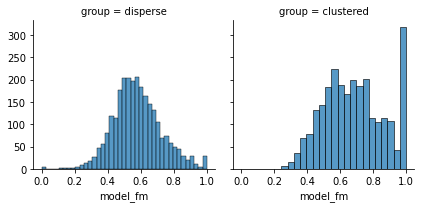

In [113]:
g = sns.FacetGrid(df, col="group")
g.map(sns.histplot, "model_fm")

In [114]:
model_fms = df.groupby(['participant_id', 'base_uuid']).agg({'model_fm': 'mean'})
model_fms = model_fms.reset_index()
model_fms

,participant_id,base_uuid,model_fm
0,1,0f18f0ad-f23d-4fc9-a761-3920c107550b,0.600963
1,1,0f9a9c80-cdab-4071-8d56-27965b585a10,0.634664
2,1,2bb1495b-1ef6-4943-bb48-662371f50b30,0.777196
3,1,2f24428f-632d-4374-b0ca-cb3d0ae04bc5,0.816383
4,1,2f452eee-c0bb-437c-bd4e-f35ee9fe9ff6,0.437797
...,...,...,...
2627,10038,f54baffc-bc26-4c4d-b940-824d08daf230,0.957905
2628,10038,fa83ff0a-5066-4c01-bdf6-909bc3dda074,0.402634
2629,10038,fbb6c70e-fe6e-4634-8737-975d829a36cc,0.498742
2630,10038,fccbc907-4526-43e2-8ded-142b804b471a,0.835410


In [115]:
human_fms = pd.read_csv('human_data_fm.csv')

In [116]:
merged = pd.merge(model_fms, human_fms, on=['participant_id', 'base_uuid'])

In [117]:
tmp = merged[['model_fm', 'human_fm']].dropna().to_numpy()

In [118]:
# scipy.stats.linregress(merged['model_fm'].to_numpy(), merged['fowlkes_mallows'].to_numpy())
scipy.stats.linregress(tmp)

LinregressResult(slope=0.398708982154085, intercept=0.5050941342474891, rvalue=0.3639708769274005, pvalue=3.1745506628336918e-83, stderr=0.019899178201981723)

<AxesSubplot:xlabel='model_fm', ylabel='human_fm'>

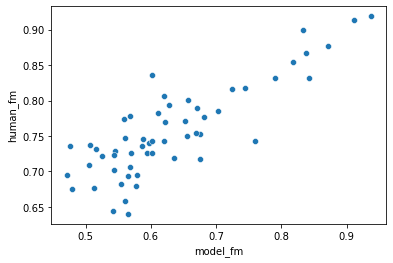

In [119]:
sns.scatterplot(x="model_fm", y="human_fm", data=merged.groupby(["base_uuid"]).mean())

In [158]:
def plot_clustering(clustering, ax):
    return ax.scatter(clustering[:, 0], clustering[:, 1], c = clustering[:, 2], s = 50)

<Figure size 432x288 with 0 Axes>

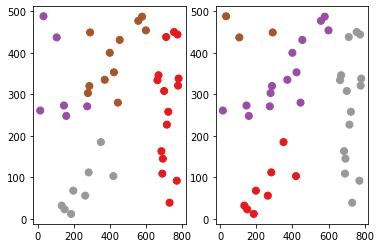

In [159]:
plt.set_cmap('Set1')

# model = df[(df.model_fm > 0.8) & (df.number_of_points > 30)]['model_clusters'].iloc[0]
# human = df[(df.model_fm > 0.8) & (df.number_of_points > 30)]['human_clusters'].iloc[0]
# fig, ax = plt.subplots(ncols=2)
# plot_clustering(model, ax[0])
# plot_clustering(human, ax[1])

# plt.show(fig)
# plt.close(fig)

In [160]:
# good model clusterings
filtered = df[(df.model_fm > 0.8) & (df.number_of_points > 30)]
for idx in range(0, min(10, len(filtered))):
    fig, ax = plt.subplots(ncols=2)
    plot_clustering(filtered['model_clusters'].iloc[idx], ax[0])
    plot_clustering(filtered['human_clusters'].iloc[idx], ax[1])
    fig.savefig("../images-hebbian-inhibitive-clustering/good-model-clusters/" + str(uuid.uuid4()))
    plt.close(fig)

In [161]:
# poor model clusterings
filtered = df[(df.model_fm < 0.5) & (df.number_of_points > 30)]
for idx in range(0, min(10, len(filtered))):
    fig, ax = plt.subplots(ncols=2)
    plot_clustering(filtered['model_clusters'].iloc[idx], ax[0])
    plot_clustering(filtered['human_clusters'].iloc[idx], ax[1])
    fig.savefig("../images-hebbian-inhibitive-clustering/poor-model-clusters/" + str(uuid.uuid4()))
    plt.close(fig)

## Tests with custom ground truth

In [218]:
def gen_points(x_mean, y_mean, x_sigma, y_sigma, x_y_cov, n_samples, cluster_number):
    ret = np.random.multivariate_normal([x_mean, y_mean],
                                        [[x_sigma ** 2, x_y_cov], [x_y_cov, y_sigma ** 2]],
                                        n_samples)
    return np.hstack((ret, np.repeat(cluster_number, n_samples).reshape(n_samples, 1)))



stims = []
for number_of_points in range(10, 41, 10):
    for number_of_clusters in range(2, 10):
        for sd in range(10, 200, 30):
            for _ in range(4):
                stim_tmp = []
                for idx in range(number_of_clusters):
                    cluster = gen_points(
                        np.random.randint(800), np.random.randint(500), sd, sd, 0,
                        number_of_points // number_of_clusters, idx)
                    stim_tmp.append(cluster)
                stims.append(dict(clusters=np.vstack(stim_tmp),
                                  number_of_points=number_of_points,
                                  number_of_clusters=number_of_clusters,
                                  sd = sd))



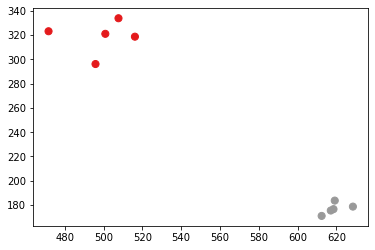

In [219]:
fig, ax = plt.subplots()
plot_clustering(stims[0]["clusters"], ax)
plt.show()
plt.close(fig)

In [220]:
def fit_model(raw_data):
    raw_points = raw_data[:, :2]
    network = Network.generate_initial(raw_points)
    clusters = network.fit(raw_points)
    return clusters

for stim in tqdm(stims):
    try:
        model_clusters = fit_model(stim['clusters'])
        stim['model_clusters'] = model_clusters
    except:
        stim['model_clusters'] = math.nan 
    

100%|██████████| 896/896 [02:02<00:00,  7.29it/s]


In [221]:
for stim in tqdm(stims):
    if isinstance(stim['model_clusters'], np.ndarray):
        stim['model_fm'] = utility.calc_fowlkes_mallows(stim['clusters'], stim['model_clusters'])
    else:
        stim['model_fm'] = math.nan

100%|██████████| 896/896 [00:00<00:00, 2090.54it/s]


In [226]:
ground_truth_table = pd.DataFrame.from_dict(stims)
ground_truth_table

,clusters,number_of_points,number_of_clusters,sd,model_clusters,model_fm
0,"[[471.60597640159955, 323.08110198299113, 0.0]...",10,2,10,"[[471.60597640159955, 323.08110198299113, 1.0]...",1.000000
1,"[[70.7890711313536, 388.4072455360802, 0.0], [...",10,2,10,"[[70.7890711313536, 388.4072455360802, 0.0], [...",1.000000
2,"[[88.79736402313112, 333.6268610453511, 0.0], ...",10,2,10,"[[88.79736402313112, 333.6268610453511, 0.0], ...",1.000000
3,"[[147.1115998998327, 108.71406921795585, 0.0],...",10,2,10,"[[147.1115998998327, 108.71406921795585, 0.0],...",1.000000
4,"[[266.2832919943842, 229.81265909790577, 0.0],...",10,2,40,"[[266.2832919943842, 229.81265909790577, 0.0],...",1.000000
...,...,...,...,...,...,...
891,"[[-14.572238612259724, 536.539992640691, 0.0],...",40,9,160,"[[-14.572238612259724, 536.539992640691, 3.0],...",0.358399
892,"[[108.40233100307412, 527.8159427332241, 0.0],...",40,9,190,"[[108.40233100307412, 527.8159427332241, 3.0],...",0.251400
893,"[[328.489703412482, 462.9387460578963, 0.0], [...",40,9,190,"[[328.489703412482, 462.9387460578963, 0.0], [...",0.221710
894,"[[651.5404187304661, 588.4618729904616, 0.0], ...",40,9,190,"[[651.5404187304661, 588.4618729904616, 0.0], ...",0.333678


In [229]:
ground_truth_table.dropna().groupby(['number_of_clusters', 'sd', 'number_of_points']).mean().reset_index()

,number_of_clusters,sd,number_of_points,model_fm
0,2,10,10,1.000000
1,2,10,20,1.000000
2,2,10,30,1.000000
3,2,10,40,1.000000
4,2,40,10,0.700227
...,...,...,...,...
219,9,160,40,0.313428
220,9,190,10,0.000000
221,9,190,20,0.239386
222,9,190,30,0.321423


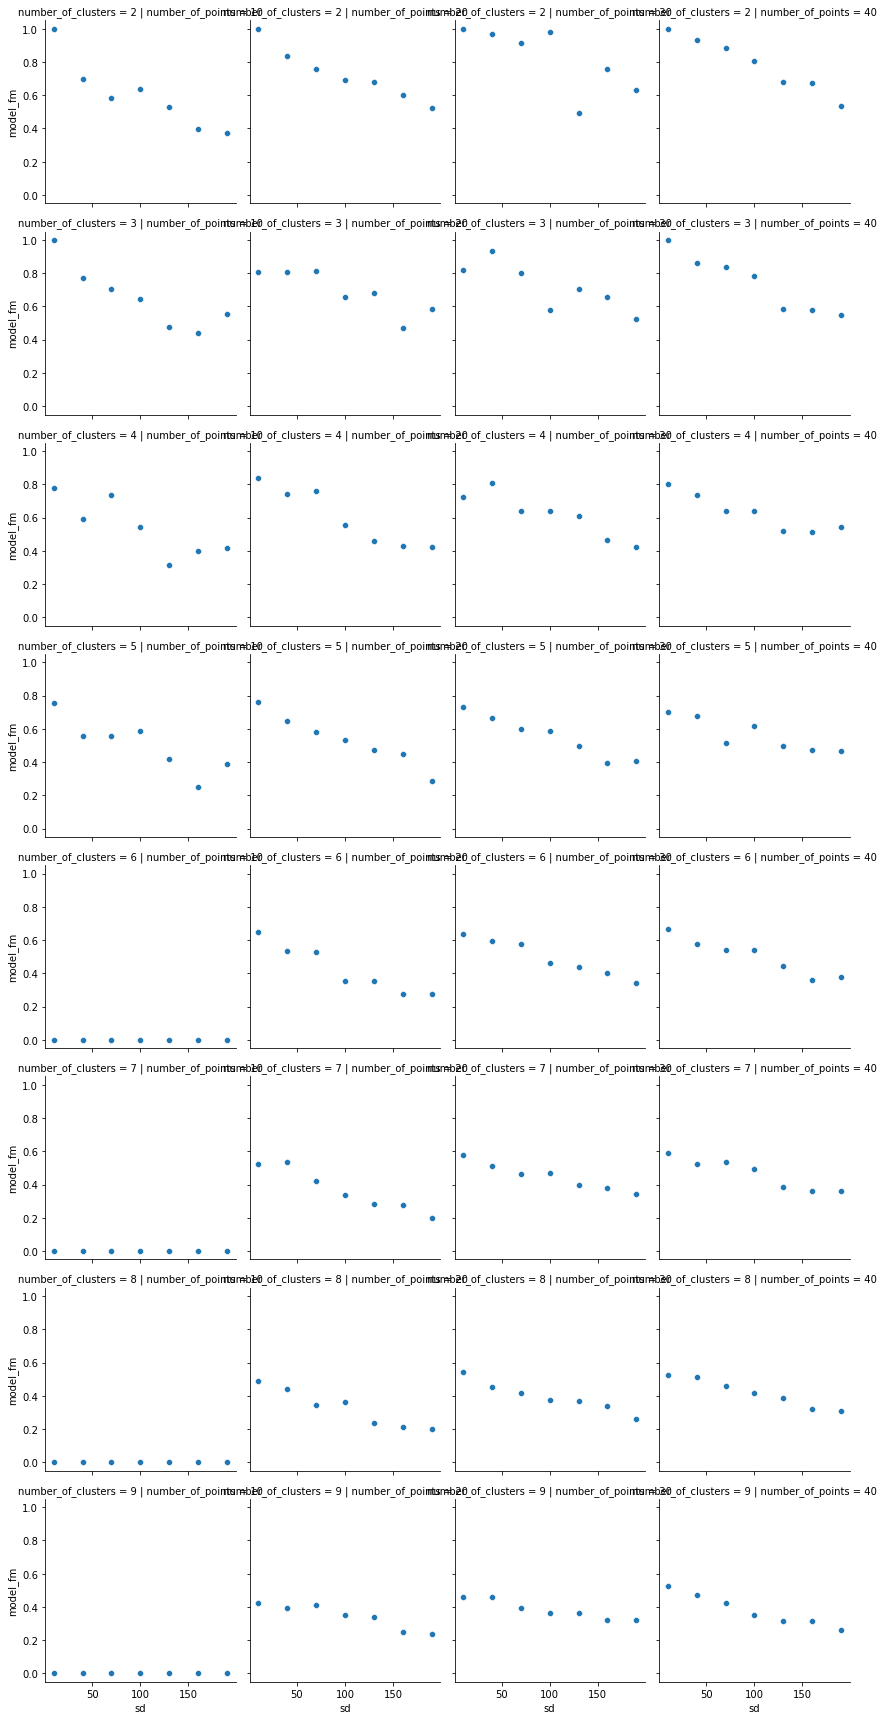

In [230]:
g = sns.FacetGrid(ground_truth_table.dropna().groupby(['number_of_clusters', 'sd', 'number_of_points']).mean().reset_index(), col="number_of_points", row="number_of_clusters")
g.map(sns.scatterplot, "sd", "model_fm")